# Modern Era instrumental data

We will use instrumental data for temperature and CO2 measurements.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

## Temperature data

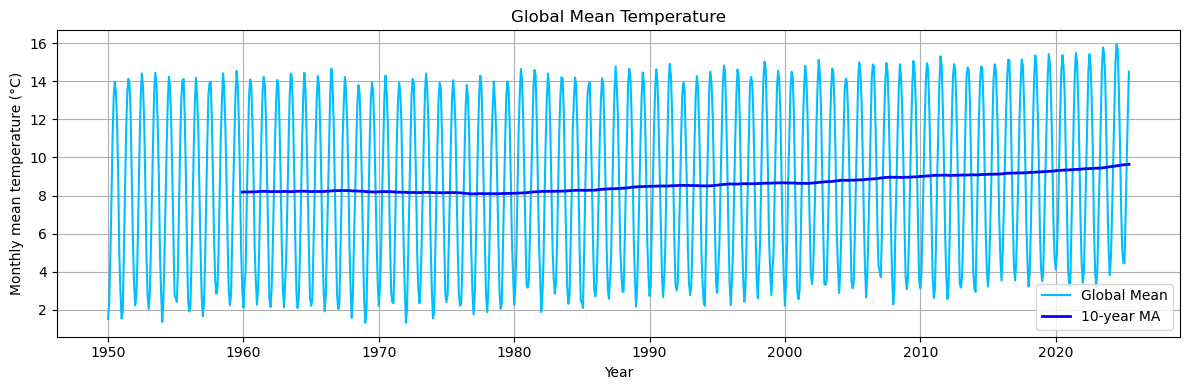

In [17]:
load_data = True
# Below we make use of global mean Temperature from ERA5 Reanalysis data.
if load_data == True:
    global_mean = pd.read_csv("../data/global_mm_temperature.csv", index_col="time", parse_dates=True).squeeze('columns')
    global_mean.name="temperature"
else:
    era5path = r"C:\Users\camen\Desktop\capstone\data\data_stream-moda.nc"
    ds = xr.open_dataset(era5path)
    print(ds)
    # We only need the 2-meter air temperature (t2m) variable, averaged over the globe:
    t2m = ds['t2m'] # accessing xarray
    weights = np.cos(np.deg2rad(ds.latitude)) # computing spatial m ean, standard practice for nc files
    global_mean = t2m.weighted(weights).mean(dim=['latitude', 'longitude']) - 273.15
    global_mean = global_mean.to_series()
    global_mean.index = pd.to_datetime(global_mean.index)
    # Saving computations to csv for quick loading next time:
    weights.to_series().to_csv("../data/latitude_weights.csv", index_label="latitude")
    global_mean.to_csv("../data/global_mm_temperature.csv", index_label="time")

window_size=120
# temperature_ma = global_mean.rolling(window=window_size, center=True).mean()
temperature_ma = global_mean.rolling(window=window_size).mean()

plt.figure(figsize=(12, 4))
plt.plot(global_mean, color='deepskyblue', label='Global Mean')
plt.plot(temperature_ma, label=f'{window_size//12}-year MA', color='blue', linewidth=2)
plt.title('Global Mean Temperature')
plt.ylabel('Monthly mean temperature (°C)')
plt.xlabel('Year')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Deseasoning

We will try to remove the seasonality and do the experiment on the "deseasoned" datasets as well, as the causal methods we are dealing with often assume stationarity of the datasets. A deseasoning process is followed below:

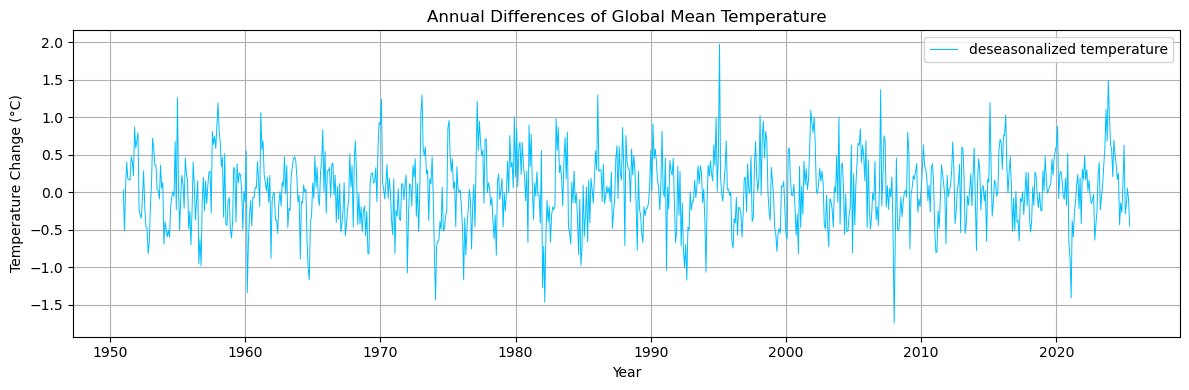

In [3]:
temp_deseasonalized = global_mean.copy()
temp_annual_diff = temp_deseasonalized.diff(12).dropna()

plt.figure(figsize=(12, 4))
plt.plot(temp_annual_diff, color='deepskyblue', label="deseasonalized temperature", linewidth=0.7)
plt.title('Annual Differences of Global Mean Temperature')
plt.ylabel('Temperature Change (°C)')
plt.xlabel('Year')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [4]:
# we'll save these datasets as well
temp_annual_diff.to_csv("../data/temp_deseasonalized.csv", index_label="time")

#### Temperature lags

We'll acquire drifted temperature datasets for up to -6 lags, in order to test the LKIFR for all lags.

## CO2 data

In [5]:
co2path = r"C:\Users\camen\Documents\GitHub\causal-discovery\data\co2_mm_mlo.csv"
co2 = pd.read_csv(co2path, comment='#')

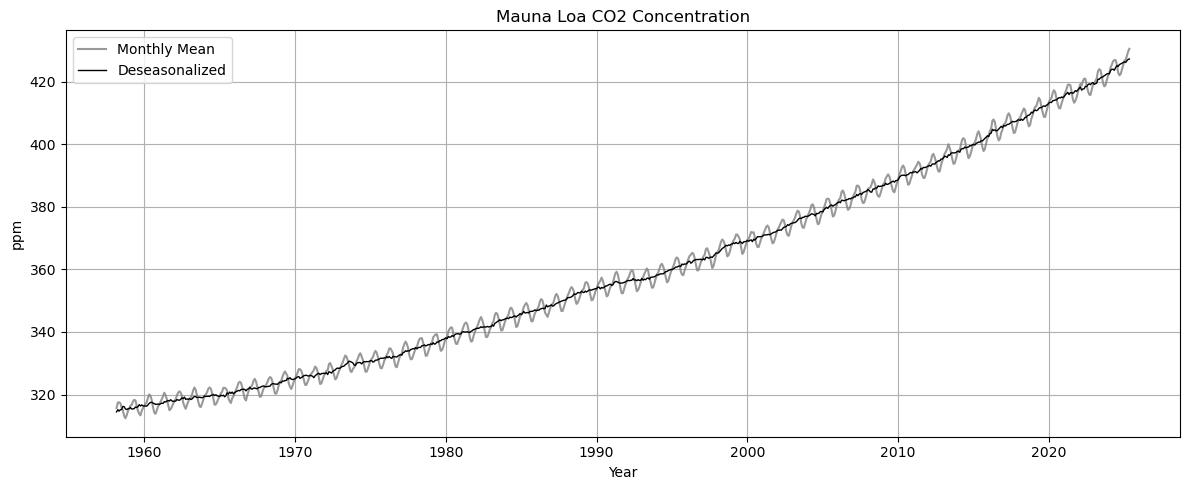

In [6]:
# datetime index for alignment
co2['date'] = pd.to_datetime(co2[['year', 'month']].assign(day=1))
co2.set_index('date', inplace=True)

plt.figure(figsize=(12, 5))
plt.plot(co2.index, co2['average'], label="Monthly Mean", alpha=0.8, color='grey')
plt.plot(co2.index, co2['deseasonalized'], label="Deseasonalized",linewidth=1, color='black')
plt.title('Mauna Loa CO2 Concentration')
plt.ylabel('ppm')
plt.xlabel('Year')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
# aligning dates to plot together
start, end = max(co2.index.min(), global_mean.index.min()), min(co2.index.max(), global_mean.index.max())
co2, global_mean = co2.loc[start:end], global_mean.loc[start:end]

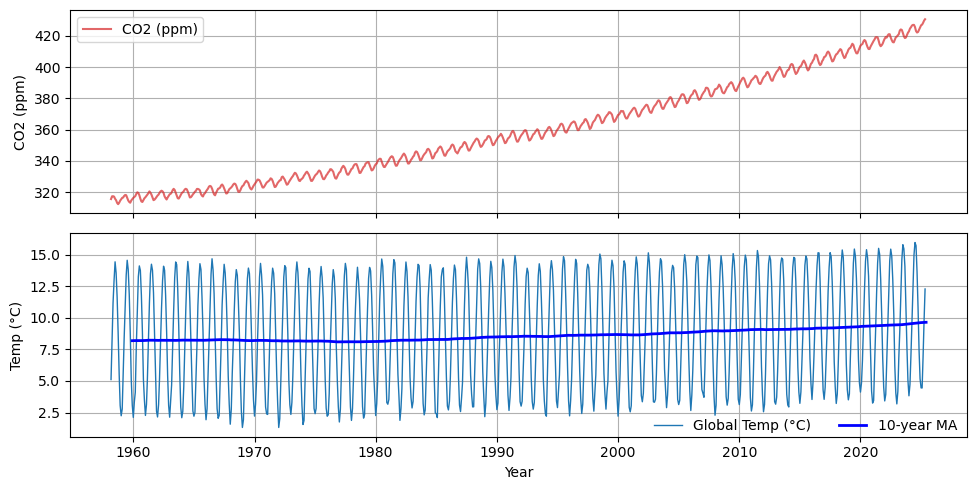

In [20]:
# plotting together
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
ax1.plot(co2.index, co2['average'], label='CO2 (ppm)', color='tab:red', alpha=0.7)
# ax1.plot(co2.index, co2['deseasonalized'], label='noaa deseasonalized', color='tab:grey', linewidth=1)
ax2.plot(global_mean.index, global_mean, linewidth=1, label='Global Temp (°C)', color='tab:blue')
ax2.plot(temperature_ma, label=f'{window_size//12}-year MA', color='blue', linewidth=2)

ax1.set_ylabel('CO2 (ppm)'); ax1.legend(); ax1.grid()
ax2.set_ylabel('Temp (°C)'); ax2.set_xlabel('Year');  ax2.legend(loc='upper center', bbox_to_anchor=(0.82, 0.15),
          ncol=2, frameon=False); ax2.grid()

plt.tight_layout()
plt.show()

Here, the `co2['deaseasonalized']` comes directly from NOAA's preprocessing. For a first experiment in the `main` notebook, we will use this series together with the plain global monthly mean temperature dataset, and for a second experiment we will proceed as follows:

As we did before for the temperatures, we will try to remove the seasonality for the CO2 concentration as well in the exact same manner, as the causal methods we are dealing with often assume stationarity of the datasets. Plus, it is wiser to work with similarily preprocessed timeseries. A deseasoning process is followed below:

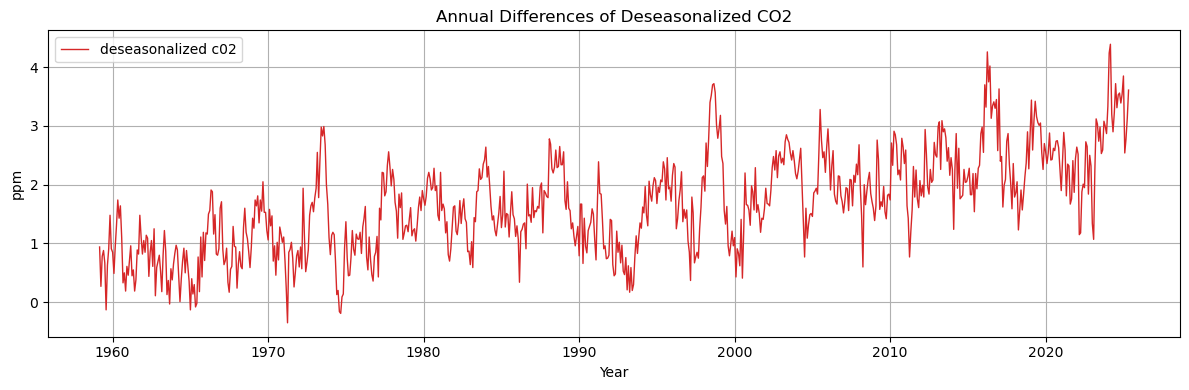

In [9]:
co2_series = co2["average"] 
deseasonalized_co2 = co2_series.copy()
co2_annual_diff = deseasonalized_co2.diff(12)

plt.figure(figsize=(12, 4))
plt.plot(co2_annual_diff, label="deseasonalized c02", linewidth=1, color='tab:red')
plt.title('Annual Differences of Deseasonalized CO2')
plt.ylabel('ppm')
plt.xlabel('Year')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
co2_annual_diff.name = "co2_annual_differences"
co2_annual_diff.to_csv("../data/co2_annual_diff.csv", index_label="date")

Plotting again the deseasonalized series together

In [11]:
start, end = max(co2_annual_diff.index.min(), temp_annual_diff.index.min()), min(co2_annual_diff.index.max(), temp_annual_diff.index.max())
co2_annual_diff, temp_annual_diff = co2_annual_diff.loc[start:end], temp_annual_diff.loc[start:end]

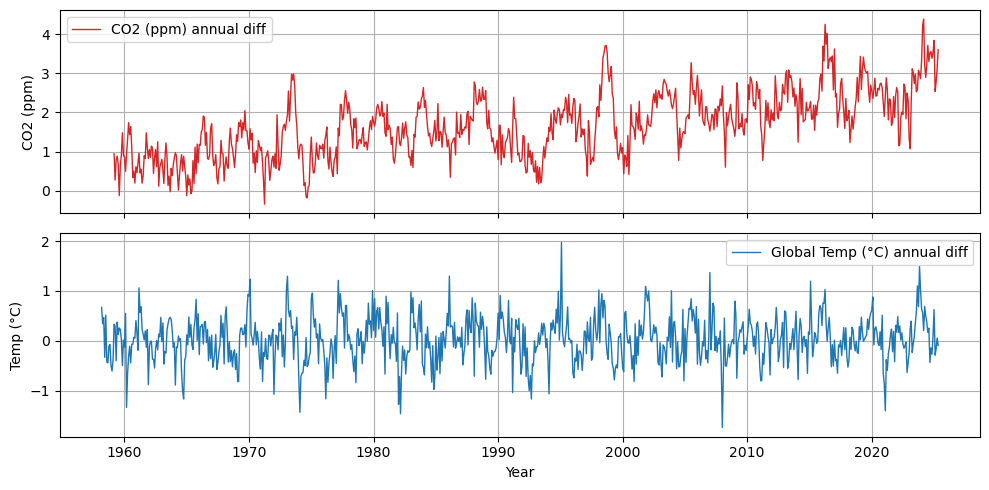

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
ax1.plot(co2_annual_diff.index, co2_annual_diff, label='CO2 (ppm) annual diff',linewidth=1, color='tab:red')
ax2.plot(temp_annual_diff.index, temp_annual_diff, linewidth=1, label='Global Temp (°C) annual diff', color='tab:blue')
ax1.set_ylabel('CO2 (ppm)'); ax1.legend(); ax1.grid()
ax2.set_ylabel('Temp (°C)'); ax2.set_xlabel('Year'); ax2.legend(); ax2.grid()
plt.tight_layout()
plt.show()

In [13]:
df = pd.DataFrame({
    'temperature': global_mean,
    'co2': co2['deseasonalized']
}).dropna()
df

,temperature,co2
1958-03-01,5.110323,314.44
1958-04-01,8.125792,315.16
1958-05-01,11.181393,314.69
1958-06-01,12.985923,315.15
1958-07-01,14.422375,315.20
...,...,...
2025-01-01,4.449924,426.35
2025-02-01,4.444533,426.15
2025-03-01,6.837699,426.69
2025-04-01,9.779043,427.13


In [14]:
df.to_pickle("../data/temp_co2_aligned.pkl")

In [15]:
df_both_deseasoned = pd.DataFrame({
    'temperature_deseasoned': temp_annual_diff,
    'co2_deseasoned': co2_annual_diff
}).dropna()
df_both_deseasoned

,temperature_deseasoned,co2_deseasoned
1959-03-01,0.330670,0.94
1959-04-01,0.294811,0.27
1959-05-01,-0.400817,0.78
1959-06-01,0.376145,0.88
1959-07-01,0.123718,0.67
...,...,...
2025-01-01,0.626188,3.85
2025-02-01,-0.290660,2.54
2025-03-01,-0.167666,2.77
2025-04-01,0.053675,3.13


In [16]:
df_both_deseasoned.to_pickle("../data/temp_co2_aligned_deeasoned.pkl")